#CS985/6 Spotify Classification Problem 2024
##Team Name: CS985MLDAGroup24
##Team Overview:
|                                              Name                                              | Student Number |         Assignment        |
|:----------------------------------------------------------------------------------------------:|:--------------:|:-------------------------:|
|     [Blacklock, Maximus]( https://classes.myplace.strath.ac.uk/user/profile.php?id=155908)     |    202382157   |         Regression        |
|     [Egbine, Akpotu Felix](https://classes.myplace.strath.ac.uk/user/profile.php?id=215949)    |    202359815   |       Classification      |
|      [Nguyen, Duc Trung](https://classes.myplace.strath.ac.uk/user/profile.php?id=214476)      |    202383238   | Classification/Regression |
|      [Thompson, Alasdair](https://classes.myplace.strath.ac.uk/user/profile.php?id=210686)     |    202383138   |         Regression        |
| [Turnbull, Christopher David](https://classes.myplace.strath.ac.uk/user/profile.php?id=213011) |    202350380   |       Classification      |

<a id="1"></a>
##Importing/Installing Libraries & Datafiles
<a id="1.1"></a>
###1.1 - Importing/Installing Libraries

In [ ]:
#@title
#This cell handles all package installations required to run the notebook

#Package installations
!pip install xgboost
!pip install gdown
!pip install tensorflow
!pip install nbconvert[webpdf]

In [13]:
#@title
#This cell handles all library/module imports required to run the notebook

#Data manipulation and analysis libraries
import pandas as pd

#Data retrieval libraries
import gdown

#Machine learning libraries
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PowerTransformer, RobustScaler, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import xgboost as xgb

#Scientific computing libraries
import numpy as np
from scipy.stats import ks_2samp

#Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Misc
import warnings
warnings.filterwarnings('ignore')

<a id="1.2"></a>
###1.2 - Importing Datasets

In [14]:
#@title
#Storing the Google Drive URL of the .csv files to be downloaded
train_url, test_url='https://drive.google.com/uc?id=1xta0FaTHYVKjLbc7ztPgDME5nsqZGoPz', 'https://drive.google.com/uc?id=1O0DtiXCsgl7CDV52yOvVWwaKriXjqWxL'

#Storing the output path of the .csv files to be downloaded
train_file, test_file='CS98XClassificationTrain.csv', 'CS98XClassificationTest.csv'

#Downloading the .csv files from Google Drive
gdown.download(train_url, train_file, quiet=False); gdown.download(test_url, test_file, quiet=False)

#Reading the .csv files into a DataFrame
train_set, test_set=pd.read_csv(train_file), pd.read_csv(test_file)

#Renaming the 'top genre' column to 'top_genre' in the 'train_set' and 'test_set' DataFrames for the purpose of accessibility
train_set.rename(columns={'top genre': 'top_genre'}, inplace=True); test_set.rename(columns={'top genre': 'top_genre'}, inplace=True)

Downloading...
From: https://drive.google.com/uc?id=1xta0FaTHYVKjLbc7ztPgDME5nsqZGoPz
To: /content/CS98XClassificationTrain.csv
100%|██████████| 39.1k/39.1k [00:00<00:00, 55.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1O0DtiXCsgl7CDV52yOvVWwaKriXjqWxL
To: /content/CS98XClassificationTest.csv
100%|██████████| 8.57k/8.57k [00:00<00:00, 16.1MB/s]


<a id="2"></a>
##2 - Data Cleaning and Exploration
<a id="2.1"></a>
###2.1 - Investigating Duplicate Rows


In [15]:
#@title
#Checking for duplicate rows in the 'train_set' and 'test_set' DataFrames using the 'Id' columns
print(f"There are {train_set.duplicated(subset='Id').sum()} duplicate 'Id' values in the 'train_set' DataFrame")
print(f"There are {test_set.duplicated(subset='Id').sum()} duplicate 'Id' values in the 'test_set' DataFrame")

#Checking for duplicate rows in the 'train_set' and 'test_set' DataFrames excluding the 'Id' columns
print(f"There are {train_set.drop(columns='Id').duplicated().sum()} duplicate rows in the 'train_set' DataFrame with the 'Id' column excluded")
print(f"There are {test_set.drop(columns='Id').duplicated().sum()} duplicate rows in the 'test_set' DataFrame with the 'Id' column excluded")

There are 0 duplicate 'Id' values in the 'train_set' DataFrame
There are 0 duplicate 'Id' values in the 'test_set' DataFrame
There are 1 duplicate rows in the 'train_set' DataFrame with the 'Id' column excluded
There are 0 duplicate rows in the 'test_set' DataFrame with the 'Id' column excluded


So we will drop the duplicate row since ID is not a differentiate factor.

In [16]:
#@title
#Handling duplicate rows in the 'train_set' DataFrame
train_set=train_set.drop_duplicates(subset=train_set.columns.difference(['Id']))
#Resetting the index of the 'train_set' DataFrame to handle the dropped rows
train_set.reset_index(drop=True, inplace=True)

<a id="2.2"></a>
###2.2 - Comparing the Distribution of the Numerical Columns in the Train and Test Datasets

We are performing classificaiton on 80 classes, using a relatively small dataset, having only 452 songs for training, meaning an average of 5 songs per genre, so we need to check if the train and test set are statistically similar enough for modeling.

In [17]:
#Storing the numerical columns from the 'train_set' and 'test_set' DataFrames in separate DataFrames
train_set_numerical, test_set_numerical=train_set.select_dtypes(include=[np.number]), test_set.select_dtypes(include=[np.number])

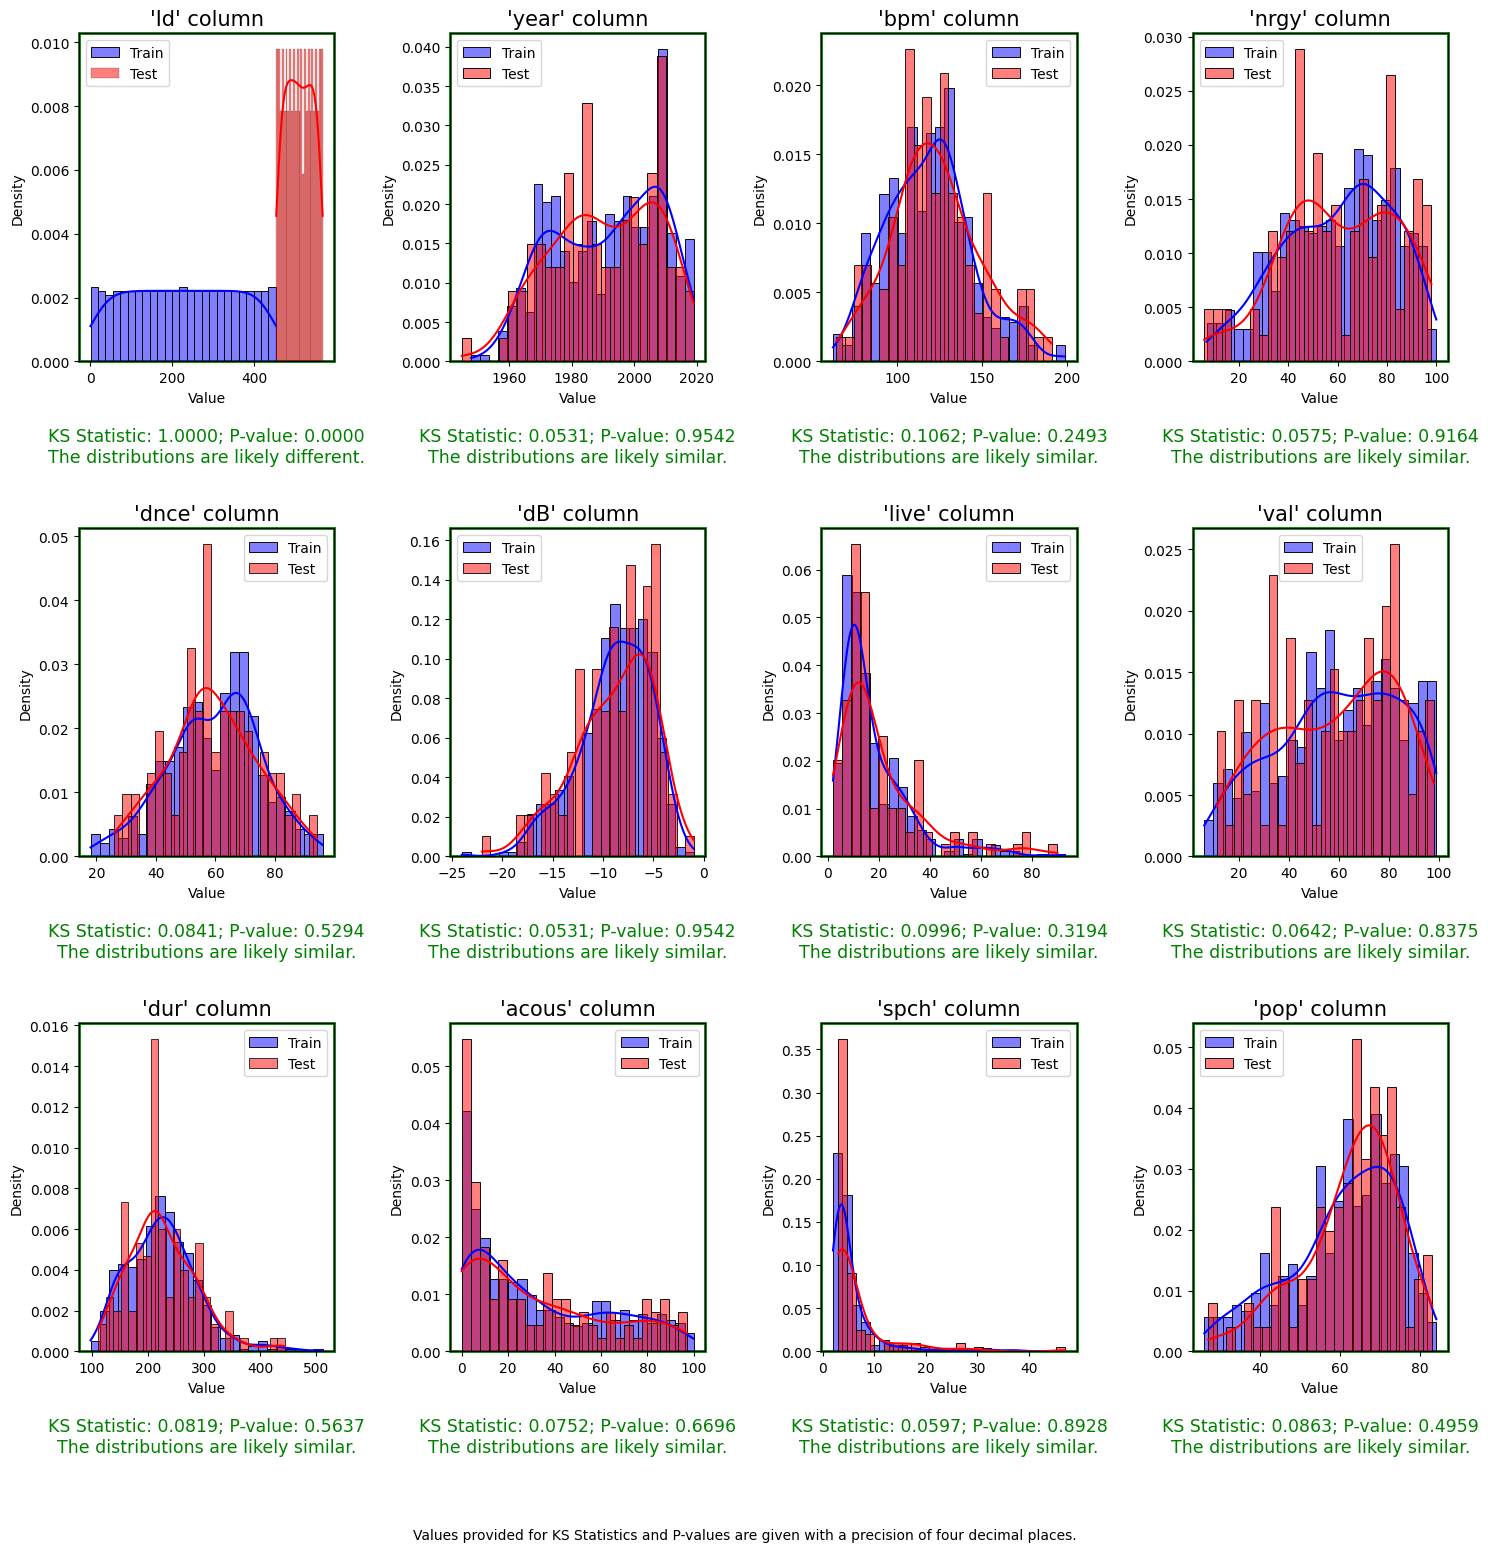

In [18]:
#@title
#Storing the number of numerical columns in the 'train_set' DataFrame inside a variable
num_cols=len(train_set_numerical.columns)

#Creating a subplot for each numerical column in the 'train_set' and 'test_set' DataFrames
fig, axes=plt.subplots(num_cols // 4, 4, figsize=(15, 15))
axes=axes.flatten()

for i in range(num_cols):
    ax=axes[i]
    #Overlaying histogram and KDE plot for 'train' dataset
    sns.histplot(train_set_numerical.iloc[:, i], ax=ax, color='blue', label='Train', kde=True, stat="density", alpha=0.5, bins=25)
    #Overlaying histogram and KDE plot for 'test' dataset
    sns.histplot(test_set_numerical.iloc[:, i], ax=ax, color='red', label='Test', kde=True, stat="density", alpha=0.5, bins=25)
    ax.set_xlabel("Value", fontsize=10)
    ax.set_ylabel("Density", fontsize=10)
    ax.set_title(f"'{train_set_numerical.columns[i]}' column", fontsize=15)
    ax.legend()
    ax.patch.set_edgecolor('green')
    ax.patch.set_linewidth(2)
    #Applying the Kolmogorov-Smirnov Test to the set of columns
    ks_statistic, p_value=ks_2samp(train_set_numerical.iloc[:, i], test_set_numerical.iloc[:, i])
    if p_value > 0.05:
        text="The distributions are likely similar.\n"
    else:
        text="The distributions are likely different.\n"
    ax.text(0.5, -0.2, f"KS Statistic: {ks_statistic:.4f}; P-value: {p_value:.4f}\n{text}", ha='center', va='top', transform=ax.transAxes, color='green', fontsize=12.5)

#Adjusting the layout of the plot and adding text
plt.tight_layout()
fig.text(0.5, -0.03, "Values provided for KS Statistics and P-values are given with a precision of four decimal places.", ha="center")
plt.show()

Through examination of the plots and associated Kolmogorov-Smirnov Tests above, it is safe to conclude that all the columns (excluding the 'Id' column) in the 'train_set' DataFrame have similar distributions to their counterparts in the 'test_set' DataFrame.

We also observe that multiple features has a relatively skewed distribution, like 'acous', 'spch','live','dur', but we will also need to check for outliers before concluding.

<a id="2.3"></a>
###2.3 - Investigating Missing Values

In [19]:
#@title
#Obtaining a summary of the 'train_set' DataFrame which will show any missing values
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         452 non-null    int64 
 1   title      452 non-null    object
 2   artist     452 non-null    object
 3   year       452 non-null    int64 
 4   bpm        452 non-null    int64 
 5   nrgy       452 non-null    int64 
 6   dnce       452 non-null    int64 
 7   dB         452 non-null    int64 
 8   live       452 non-null    int64 
 9   val        452 non-null    int64 
 10  dur        452 non-null    int64 
 11  acous      452 non-null    int64 
 12  spch       452 non-null    int64 
 13  pop        452 non-null    int64 
 14  top_genre  437 non-null    object
dtypes: int64(12), object(3)
memory usage: 53.1+ KB


We see that aside from the column top_genre has 15 missing values, other features are all fully populated.

<a id="2.4"></a>
###2.4 - Handling Missing Values

With only 15 missing values, we can manually fill out the song genre. While this is not an ideal solution, we can consider using classificaiton methods to impute the genre, but since building a genre classifier is the purpose of this training set, so we should enrich what available data we have with utmost certainty. For a more scalable solution, spotify's API can be access via [Spotipy](https://spotipy.readthedocs.io/en/2.9.0/), this require the song's spotify link for accuracte data crawling.

 For "I've Waited So Long - Anthony Newley", the genre can not be accurately identify between Dance and Electronic so we will drop this song, keeping a training set of 451 songs.

In [20]:
#@title
#Updating the 'top_genre' values for rows in which they are missing
train_set.loc[train_set['title'] == 'Unchained Melody', 'top_genre']='pop'
train_set.loc[train_set['title'] == 'Someone Elses Roses', 'top_genre']='adult standards'
train_set.loc[train_set['title'] == 'Drinks On The House', 'top_genre']='pop'
train_set.loc[train_set['title'] == 'Pachuko Hop', 'top_genre']='blues'
train_set.loc[train_set['title'] == 'Little Things Means A Lot', 'top_genre']='blues'
train_set.loc[train_set['title'] == 'The Lady Is A Tramp', 'top_genre']='pop'
train_set.loc[train_set['title'] == 'If I Give My Heart To You', 'top_genre']='pop'
train_set.loc[train_set['title'] == 'Happy Days And Lonely Nights','top_genre']='rock'
train_set.loc[train_set['title'] == 'Stairway Of Love','top_genre']='rock'
train_set.loc[train_set['title'] == 'You', 'top_genre']='pop'
train_set.loc[train_set['title'] == 'No Other Love' , 'top_genre']='adult standards'
train_set.loc[train_set['title'] == "Hot Diggity" , 'top_genre']='folk'
train_set.loc[train_set['title'] == "Ain't That Just the Way" , 'top_genre']='r&b'
train_set.loc[train_set['title'] == "I Promised Myself" , 'top_genre']='pop'

#Dropping rows in which the missing values for 'top_genre' could not be located (I've Waited So Long - Anthony Newley=Dance/Electronic)
train_set=train_set.dropna(axis=0)

#Resetting the index of the 'train_set' DataFrame to handle the dropped row
train_set.reset_index(drop=True, inplace=True)

#check again for null values
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         451 non-null    int64 
 1   title      451 non-null    object
 2   artist     451 non-null    object
 3   year       451 non-null    int64 
 4   bpm        451 non-null    int64 
 5   nrgy       451 non-null    int64 
 6   dnce       451 non-null    int64 
 7   dB         451 non-null    int64 
 8   live       451 non-null    int64 
 9   val        451 non-null    int64 
 10  dur        451 non-null    int64 
 11  acous      451 non-null    int64 
 12  spch       451 non-null    int64 
 13  pop        451 non-null    int64 
 14  top_genre  451 non-null    object
dtypes: int64(12), object(3)
memory usage: 53.0+ KB


<a id="2.5"></a>
###2.5 - Investigation into Outliers

In [21]:
#@title
#Storing the quantiles inside variables and calculating the interquartile range for the numerical columns of the 'train_set' DataFrame
Q1, Q3=train_set_numerical.quantile(0.25), train_set_numerical.quantile(0.75)
IQR=Q3 - Q1

#Calculating the number of outliers for each of the numerical columns in the 'train_set' DataFrame
outliers=((train_set_numerical < (Q1 - 1.5 * IQR)) | (train_set_numerical > (Q3 + 1.5 * IQR))).sum()

#Sorting the numerical columns by their number of outliers
outliers_sorted=outliers.sort_values(ascending=False)

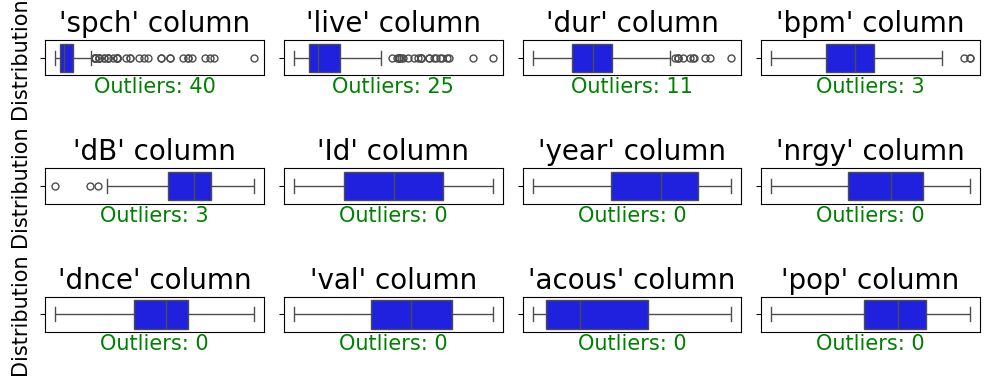

In [22]:
#@title
#Creating a subplot for each numerical column
fig, axes=plt.subplots(num_cols // 4, 4, figsize=(10, 4),sharey=True)
axes=axes.flatten()

for num, col in enumerate(outliers_sorted.index.tolist()):
    ax=axes[num]
    sns.boxplot(data=train_set_numerical[col], ax=ax, color='blue', fliersize=5,orient='h')
    ax.tick_params(axis='x', labelbottom=False)
    ax.xaxis.set_visible(False)
    ax.set_ylabel("Distribution", fontsize=15)
    ax.set_title(f"'{col}' column", fontsize=20)
    ax.text(0.5, -0.05, f"Outliers: {outliers_sorted[col]}\n", ha='center', va='top', transform=ax.transAxes, color='green', fontsize=15)

plt.tight_layout()
plt.show()

As can be seen from the boxplots and outliers counter above, numerical features such as 'spch', 'live', 'dur' have a significant number of outliers, accompaniesd with being skewed, so we will consider applying log scaling to these features

<a id="2.6"></a>
###2.6 - Investigate Classes Distribution

In [23]:
category_percentages=train_set["top_genre"].value_counts().sort_values(ascending=False).apply(lambda x: (x / 451) * 100).round(1)
category_percentages.name="Percentage of Total"
category_percentages

adult standards            15.3
album rock                 14.6
dance pop                  13.5
glam rock                   3.5
brill building pop          3.5
                           ... 
mellow gold                 0.2
avant-garde jazz            0.2
german alternative rock     0.2
acoustic blues              0.2
alternative rock            0.2
Name: Percentage of Total, Length: 88, dtype: float64

With 451 songs for 88 classes, it is already approximate 5 songs per class, the minimal number of instances recommend to apply SMOTE or other oversampling methods that employ KNN, but the class distribution are also imbalance, with 3 genres already account for 43.4%. To deal with imbalance, most models within sklearn already offers the parameter **class_weight='balanced'**, which auto adjusts the class weights inversely proportional to the class frequencies, giving more weight to minority class and less weight to majority class during training.

We also considered grouping the classes together based on naming convention or **consine similarity** but overall these options only reduce the results so we will be working with the original classes

<a id="2.7"></a>
###2.7 - Checking for correlation

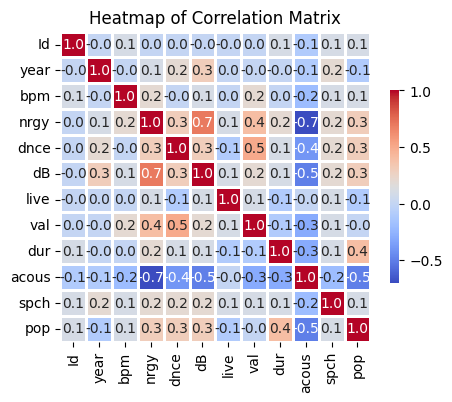

In [24]:
#@title
corr_matrix=train_set_numerical.corr().round(1)
pop_corr_sorted=corr_matrix["pop"].sort_values(ascending=False)

plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5}, edgecolor='green', linewidth=2)
plt.title('Heatmap of Correlation Matrix')
plt.show()

**From the above plot it can be seen that most features in the dataset exhibit a relatively low level of interdependence, with the notable exception of the positive correlation between 'nrgy' and 'dB' and the negative correlation between 'acous' and 'nrgy'.**

<a id="3"></a>
#3 - Feature Engineering

<a id="3.1"></a>
##3.1 - Binning Values for Year

With the year of release ranging from 1948, we would try to apply binning to the "year" features, since some genres can connects to certain time period. With the exception of the period from 1948 to 1954 that are all in group 1, the following groups are in a 5-year intervals

In [25]:
#@title
#Due to the tracks being released over such a large time span, we can simplify the data through binning by grouping the
#dates into 5 year intervals
def assign_group(year):
    if 1948 <= year <= 1954:
        return 1
    else:
        return ((year - 1954)//5)+2

#Applying the calculation
train_set['year']=train_set['year'].apply(assign_group)
test_set['year']=test_set['year'].apply(assign_group)

#Storing the current year inside a variable
current_year=pd.to_datetime('today').year

In [26]:
#@title
train_df=train_set.copy()
test_df=test_set.copy()

<a id="3.2"></a>
##3.2 - Applying TFIDF on the 'title' column

<a id="3.2.1"></a>
###3.2.1 - Train Set

In order to perform text mining on the song title, we will use TF-IDF (Term Frequency-Inverse Document Frequency), which vectorize the individual words that make up the song, allowing for representation of the feature.

But since this process will create a really big sparse matrix so we will also need to apply TruncateSVD to reduce this dimensionality. Since we are working with categorical features so some information will undoutedly be lost. By graphing the relationship between variance and number of component, we find a cut-off that allow retains 90% of information

In [27]:
#@title
#Taking the title column
text_data=train_df['title']

#Initializing the TF-IDF vectorizer
tfidf_vectorizer=TfidfVectorizer()

#Fitting the vectorizer on the text data and transforming the text data into TF-IDF features
tfidf_features=tfidf_vectorizer.fit_transform(text_data)

#Converting the result to a DataFrame
tfidf_df=pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [28]:
#@title
#Calculating the explained variance for different numbers of components
explained_variance=[]
for n in range(1, min(tfidf_df.shape)+1):
    svd=TruncatedSVD(n_components=n)
    svd.fit(tfidf_df)
    explained_variance.append(svd.explained_variance_ratio_.sum())

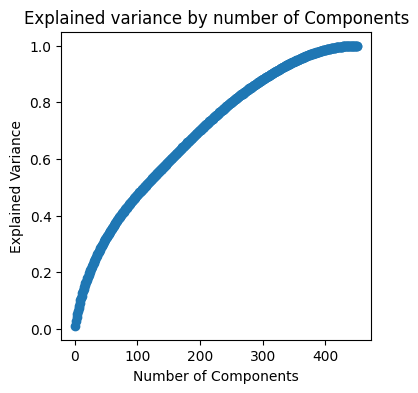

In [29]:
# @title
plt.figure(figsize=(4, 4))
#Plotting the explained variance
plt.plot(range(1, min(tfidf_df.shape)+1), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained variance by number of Components')
plt.show()

In [30]:
#@title
#Iterate over the list and find the index of the first value > 0.9
index=next((i for i, val in enumerate(explained_variance) if val > 0.9), None)

if index is not None:
    print("Index of the first value > 0.9:", index)

Index of the first value > 0.9: 313


In [31]:
#@title
#Initialize TruncateSVD
svd=TruncatedSVD(n_components=index)  #Set the desired number of components

#Apply truncatesvd to tfidf_df
tfidf_svd=svd.fit_transform(tfidf_df)

#Convert tfidf_svd to DataFrame
tfidf_svd_df=pd.DataFrame(tfidf_svd, columns=[f'tfidf_svd_{i+1}' for i in range(tfidf_svd.shape[1])])

<a id="3.2.2"></a>
###3.2.2 - Test Set

We apply the same transformation on the test set

In [32]:
#@title
#Applying the transformation on the test set
text_data=test_df['title']

#Fit the vectorizer on the text data and transform the text data into TF-IDF features
tfidf_features=tfidf_vectorizer.transform(text_data)

#Convert the result to a DataFrame
tfidf_df_test=pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

#Apply TruncateSVD to tfidf_df_test
tfidf_svd_test=svd.transform(tfidf_df_test)

#Convert tfidf_svd_test to DataFrame
tfidf_svd_test_df=pd.DataFrame(tfidf_svd_test, columns=[f'tfidf_svd_{i+1}' for i in range(tfidf_svd.shape[1])])

<a id="3.3"></a>
##3.3 - Applying One-hot Encoding to the Artist Column

<a id="3.3.1"></a>
###3.3.1 - Train Set

For artist, we apply one-hot encoding as each artist name are unique and there is no point in analysing the hidden pattern of naming for artists. From then we follow the same approach of using truncateSVD to reduce the dimensionality of the sparse matrix and graphing the result to find an optimal number of components to retain 90% variance.

In [33]:
#@title
#Initialize the OneHotEncoder
encoder=OneHotEncoder(handle_unknown='ignore') #to hanđle artists that newly appear on the test set

#Fit and transform the 'artist' column in X_train_encoded
one_hot_encoded_train=encoder.fit_transform(train_df[['artist']])

#Convert the encoded data into a DataFrame
one_hot_encoded_train_df=pd.DataFrame(one_hot_encoded_train.toarray(), columns=encoder.get_feature_names_out(['artist']))

In [34]:
#@title
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
#Calculate the explained variance for different numbers of components
explained_variance_artist=[]
for n in range(1, min(one_hot_encoded_train_df.shape)+1):
    svd=TruncatedSVD(n_components=n)
    svd.fit(one_hot_encoded_train_df)
    explained_variance_artist.append(svd.explained_variance_ratio_.sum())

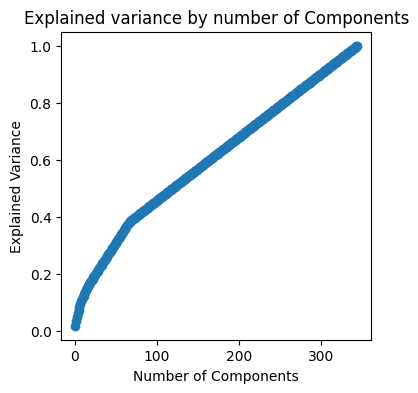

In [35]:
# @title
plt.figure(figsize=(4, 4))
#Plot the explained variance
plt.plot(range(1, min(one_hot_encoded_train_df.shape)+1), explained_variance_artist, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained variance by number of Components')
plt.show()

In [36]:
#@title
#Iterate over the list and find the index of the first value > 0.9
index=next((i for i, val in enumerate(explained_variance_artist) if val > 0.9), None)

if index is not None:
    print("Index of the first value > 0.9:", index)

Index of the first value > 0.9: 299


In [37]:
#@title
#Initialize TruncateSVD
svd=TruncatedSVD(n_components=index)  #setting the optimal values index=299

#Apply SVD to artist one hot encoding
artist_svd=svd.fit_transform(one_hot_encoded_train_df)

#Convert artist_svd_test to DataFrame
artist_svd_df=pd.DataFrame(artist_svd, columns=[f'artist_svd_{i+1}' for i in range(artist_svd.shape[1])])

<a id="3.3.2"></a>
###3.3.2 - Test Set

Then we apply the same transformation on the test set

In [38]:
#@title
#Apply trasnformation on the test set
one_hot_encoded_test=encoder.transform(test_df[['artist']])

#Convert the encoded data into a DataFrame
one_hot_encoded_test_df=pd.DataFrame(one_hot_encoded_test.toarray(), columns=encoder.get_feature_names_out(['artist']))

#Apply svd to the test set
artist_svd_test=svd.transform(one_hot_encoded_test_df)

#Convert artist_svd_test to DataFrame
artist_svd_test_df=pd.DataFrame(artist_svd_test, columns=[f'artist_svd_{i+1}' for i in range(artist_svd_test.shape[1])])

<a id="3.4"></a>
##3.4 - Concatenate the new DataFrames

Now we concatenate the new encoding columns created from artist and title to the train and test set

In [39]:
#@title
#Concatenate tfidf_svd_df
train_svd=pd.concat([train_df.reset_index(drop=True), tfidf_svd_df.reset_index(drop=True)], axis=1)

#Concatenate artist_svd_df
train_svd=pd.concat([train_svd.reset_index(drop=True), artist_svd_df.reset_index(drop=True)], axis=1)

In [40]:
#@title
#Concatenate tfidf_svd_test_df
test_svd=pd.concat([test_df.reset_index(drop=True), tfidf_svd_test_df.reset_index(drop=True)], axis=1)

#Concatenate artist_svd_test_df
test_svd=pd.concat([test_svd.reset_index(drop=True), artist_svd_test_df.reset_index(drop=True)], axis=1)

<a id="3.5"></a>
##3.5 - Dropping Unnecessary Columns

After perform feature engineering, we can remove artist and title, along with ID as this is not a differentiatign column.

In [41]:
train_svd, test_svd=train_svd.drop(['Id','artist','title'], axis=1), test_svd.drop(['Id','artist','title'], axis=1)

In [42]:
#@title
train_scaled=train_svd.copy()
test_scaled=test_svd.copy()

<a id="4"></a>
#4 - Preparing the Datasets for Training

<a id="4.1"></a>
##4.1 - Feature Scaling

In order

As we have discovered so far, 4 features 'spch', 'live', 'dur','acous' has a heavily skewed distribution with high number of outliers, and many machine learning models are design to work with more Gausian-like distribution. For this we can consider log transformation, but since we would prefer a more normal distribution so we will be using Box-cox transfromation on **'spch', 'live', 'dur'**, and a variant, Yeo-Johnson transformation for the case of **"acous"** that also contain zero

Box-cox transformation:
$$
y(\lambda)=\begin{cases}
    \frac{{y^\lambda - 1}}{{\lambda}}, & \text{if } \lambda \neq 0; \\
    \log(y), & \text{if } \lambda=0.
\end{cases}
$$

Yeo-Johnson transformation:
$$
y(\lambda)=\begin{cases}
    \frac{{(y + 1)^\lambda - 1}}{{\lambda}}, & \text{if } \lambda \neq 0 \text{ and } y \geq 0; \\
    \log(y + 1), & \text{if } \lambda=0 \text{ and } y \geq 0; \\
    -\frac{{(1 - y)^{-\lambda} - 1}}{{\lambda}}, & \text{if } \lambda \neq 0 \text{ and } y < 0; \\
    -\log(1 - y), & \text{if } \lambda=0 \text{ and } y < 0.
\end{cases}
$$
Where:
- y is the original data.
- lambda is the transformation parameter.

For the remaining features, we will apply a StandardScaler to bring all features into the same scale.

In [43]:
#@title
#Columns to apply Box-Cox and yeo-johnson transformation
boxcox_cols=['spch', 'live', 'dur']
yeo_johnson_col=['acous']

#Columns to apply StandardScaler
standard_cols=['year', 'bpm', 'nrgy', 'dnce', 'val', 'dB','pop']

#Create a pipeline for scaling data
scaling_pipeline=ColumnTransformer([
    ('boxcox', PowerTransformer(method='box-cox', standardize=False), boxcox_cols),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson', standardize=False), yeo_johnson_col),
    ('standard', StandardScaler(), standard_cols)
])

#All columns to scaled
scale_cols=boxcox_cols+yeo_johnson_col+standard_cols

#Apply the transformations
train_scaled[scale_cols]=scaling_pipeline.fit_transform(train_scaled[scale_cols])

#Convert the result back to a DataFrame (optional)
test_scaled[scale_cols]=scaling_pipeline.transform(test_scaled[scale_cols])

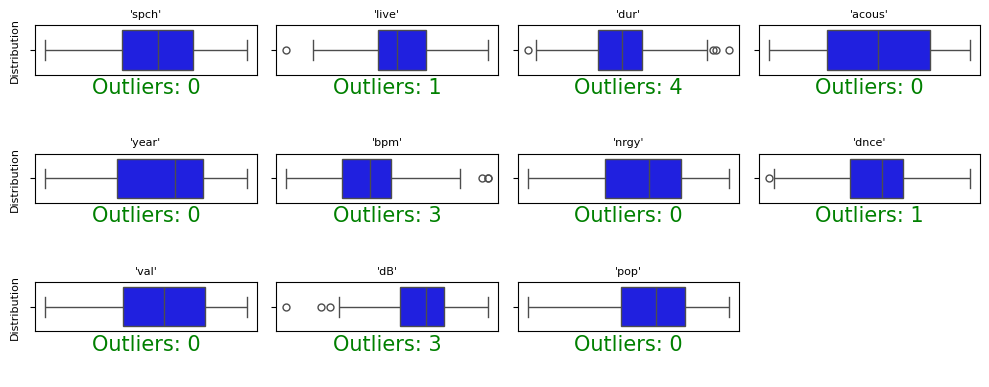

In [44]:
#@title
#Storing the quantiles inside variables and calculating the interquartile range for the numerical columns of the 'train_set' DataFrame
Q1, Q3=train_scaled[scale_cols].quantile(0.25), train_scaled[scale_cols].quantile(0.75)
IQR=Q3 - Q1

#Calculating the number of outliers for each of the numerical columns in the 'train_set' DataFrame
outliers=((train_scaled[scale_cols] < (Q1 - 1.5 * IQR)) | (train_scaled[scale_cols] > (Q3 + 1.5 * IQR))).sum()

#Again sorting the numerical columns by their number of outliers
outliers_sorted=outliers.sort_values(ascending=False)

num_cols=len(scale_cols)
cols_per_row=4
rows_needed=-(-num_cols // cols_per_row)

fig, axes=plt.subplots(rows_needed, cols_per_row, figsize=(10, 4), sharey=True)
axes=axes.flatten()

for num, col in enumerate(scale_cols):
    ax=axes[num]
    sns.boxplot(data=train_scaled[col], ax=ax, color='blue', fliersize=5, orient='h')
    ax.tick_params(axis='x', labelbottom=False)
    ax.xaxis.set_visible(False)
    ax.set_ylabel("Distribution", fontsize=8)
    ax.set_title(f"'{col}'", fontsize=8)
    ax.text(0.5, -0.05, f"Outliers: {outliers_sorted[col]}\n", ha='center', va='top', transform=ax.transAxes, color='green', fontsize=15)

for empty_ax in axes[num_cols:]:
    empty_ax.axis('off')

plt.tight_layout()
plt.show()

The distributions of each feature can be seen to be far more normal than before scaling was applied, with minimal outliers just barely outside the normal range, posing little effect.

<a id="5.3"></a>
###5.3 - Label Encoding

While most of the models from sklearn does not explicitly require label encoding to work, it is still a good practice, and XGBoost does not have this functionality. Since we will be splitting the train data into X_train, X_test, y_train, y_test, but a few genres only containing 1 single song so during encoding of the y_test, there will be unseen label, hence we make a LabelEncoderExt for this scenario.

In [45]:
y_scaled=train_scaled['top_genre']
X_scaled=train_scaled.drop(['top_genre'], axis=1)

In [46]:
#@title
class LabelEncoderExt(object):
    def __init__(self):
        """
        Allow handling unseen classes and apply a default class id
        """
        self.label_encoder=LabelEncoder()
        #self.classes_=self.label_encoder.classes_
    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder=self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_=self.label_encoder.classes_
        return self
    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list=list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list=['Unknown' if x==unique_item else x for x in new_data_list]
        return self.label_encoder.transform(new_data_list)

    def inverse_transform(self, encoded_list):
        """
        Return the encoded values to it original values
        :param encoded_list: A list of encoded values
        :return: A list of original values
        """
        decoded_list=self.label_encoder.inverse_transform(encoded_list)
        return decoded_list

In [47]:
X_train, X_test, y_train, y_test=train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [48]:
#@title
label_encoder1=LabelEncoderExt()
label_encoder1.fit(y_train)
y_train, y_test=label_encoder1.transform(y_train), label_encoder1.transform(y_test)

<a id="6"></a>
##6 - Choosing the Model

<a id="6.1"></a>
###6.1 - Single Model

We create a dictionary to track the result of the models

In [49]:
model_info={}

<a id="6.1.1"></a>
####6.1.1 - Logistic Regression

We start out with 2 models of logistic regression, with the only different is the parameter class_weight='balanced'. We observe that, not setting the parameter actually help double the accuracy  
This is because the model is heavily affected by the 3 dominating classes. The intuition can be similar to when we have been mostly listening to rock and pop, and we start categorizing other similar genre all into these major groups. We would have a high accuracy, and probably a high recall rate too, but a terrible precision.  

This is just an example, following models will all have balanced classes since we would want a "generalized model", not focusing on just majority classes

In [50]:
#@title
#Initialize and fit the logistic regression model
model=LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

#Make predictions on the test set
y_pred=model.predict(X_test)

#Calculate accuracy
accuracy=accuracy_score(y_test, y_pred)
print("LogisticRegression Accuracy without weight balancing:", accuracy)
#Saving the result
model_info[model]=accuracy

LogisticRegression Accuracy without weight balancing: 0.4945054945054945


In [51]:
#@title
#Initialize and fit the logistic regression model
model=LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')
model.fit(X_train, y_train)

#Make predictions on the test set
y_pred=model.predict(X_test)

#Calculate accuracy
accuracy=accuracy_score(y_test, y_pred)
print("LogisticRegression Accuracy with weight balancing:", accuracy)

model_info[model]=accuracy

LogisticRegression Accuracy with weight balancing: 0.21978021978021978


<a id="6.1.2"></a>
####6.1.2 - SVC

For SVC, we know that the 'linear' kernel is good for dealing with imbalanced dataset and we will set this as default, and compare to the logistic regression, we can see an improvement to around 40% mark

In [52]:
#@title
#Which one of these cells to keep? the one with the class_weight=balanced or the one without?
#Initialize and fit the SVC model
svc_model=SVC(random_state=42, class_weight='balanced', kernel= 'linear') #linear Kernel work well with imbalanced dataset
svc_model.fit(X_train, y_train)

#Make predictions on the test set
svc_y_pred=svc_model.predict(X_test)

#Calculate accuracy for SVC
accuracy=accuracy_score(y_test, svc_y_pred)
print("SVC Accuracy:", accuracy)

model_info[svc_model]=accuracy

SVC Accuracy: 0.3956043956043956


<a id="6.1.3"></a>
####6.1.3 - Random Forest

While we expected random forest to perform better than SVM because it can handdle high dimensional data and effective in capturing complex nonlinear relationship, but the initial result is within expectation

In [53]:
#@title
#Random forest
rfc_model=RandomForestClassifier(random_state=42, class_weight='balanced')
rfc_model.fit(X_train, y_train)

#Make predictions on the test set
y_pred=rfc_model.predict(X_test)

#Calculate accuracy for SVC
accuracy=accuracy_score(y_test, y_pred)
print("RandomForestClassifier Accuracy:", accuracy)

model_info[rfc_model]=accuracy

RandomForestClassifier Accuracy: 0.3956043956043956


<a id="6.1.4"></a>
####6.1.4 - AdaBoost

Another ensemble method we consider is Adaptive Boosting (AdaBoost), but consider AdaBoost is not particularly better with sparse data comparing to SVM, and are not robust against outliers compare to random forest, but it is expected to be effective with small-sized dataset.

In [54]:
#@title
#Initialize and fit the AdaBoostClassifier model
adb_model=AdaBoostClassifier()
adb_model.fit(X_train, y_train)

#Make predictions on the test set
adaboost_y_pred=adb_model.predict(X_test)

#Calculate accuracy for AdaBoostClassifier
adb_accuracy=accuracy_score(y_test, adaboost_y_pred)
print("AdaBoostClassifier Accuracy:", adb_accuracy)

model_info[adb_model]=adb_accuracy

AdaBoostClassifier Accuracy: 0.2857142857142857


<a id="6.1.5"></a>
###6.1.5 - XGBoost

 XGBoost include regularization techniques such as shrinkage (learning rate) and column subsampling (feature importance), which can help prevent overfitting and improve generalization performance. Overall, XGBoost is expected to be a good candidate and also return the best result so far, at over >41%

In [55]:
#@title
#Encode again so the values are in order
label_encoder2=LabelEncoder()
label_encoder2.fit(y_train)
y_train_xgb= label_encoder2.transform(y_train)
#Init classifier
xgb_model=xgb.XGBClassifier(enable_categorical=True, random_state =42)

#Fit
xgb_model.fit(X_train, y_train_xgb)

#Predict
y_pred=xgb_model.predict(X_test)

#Inverse result
y_pred=label_encoder2.inverse_transform(y_pred)

#Score
accuracy=accuracy_score(y_test, y_pred)
print("XGBClassifier Accuracy:", accuracy)

#Saving the result
model_info[xgb_model]=accuracy

XGBClassifier Accuracy: 0.4175824175824176


<a id="6.2"></a>
##6.2 - Hyperparameter Tuning

As the process of hyperparameter tuning can be quite time-consuming so we have hardcode some parameter and left some parameter for tuning, each model should require around 5' to perform tuning, with adaboost could potentially take 10'

<a id="6.2.1"></a>
###6.2.1 - Logistic

In [56]:
# @title
#Define the logistic regression model
logistic_regression_model=LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear', random_state=42)

#Define the parameter grid to search
param_grid={
    'penalty': ['l1','l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }

#Create the GridSearchCV object
grid_search=GridSearchCV(logistic_regression_model, param_grid, cv=5, scoring='accuracy')

#Fit the grid search to the data
grid_search.fit(X_train, y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Get the best model
best_model=grid_search.best_estimator_

#Make predictions on the testing data
y_pred=best_model.predict(X_test)

#Evaluate the model
accuracy=accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

model_info[best_model]=accuracy

#Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'} => C=100 suggest possibility of overfitting
#Accuracy: 0.5824

KeyboardInterrupt: 

<a id="6.2.2"></a>
###6.2.2 - Linear SVC

In [ ]:
# @title
#Define the logistic regression model
lsvc_model=LinearSVC(random_state=42, class_weight='balanced',penalty="l2")

#Define the parameter grid to search
param_grid={
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'loss': ['hinge', 'squared_hinge']
    }

#Create the GridSearchCV object
grid_search=GridSearchCV(lsvc_model, param_grid, cv=5, scoring='accuracy')

#Fit the grid search to the data
grid_search.fit(X_train, y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Get the best model
best_model=grid_search.best_estimator_

#Make predictions on the testing data
y_pred=best_model.predict(X_test)

#Evaluate the model
accuracy=accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

model_info[best_model]=accuracy

<a id="6.2.3"></a>
###6.2.3 - SVC

In [ ]:
# @title
svc_model=SVC(random_state=42, class_weight='balanced', max_iter=1000, degree=1, probability= True)

#Define the parameter grid to search
param_grid={
    'C': [0.001,0.1, 1, 10,100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
}

#Create the GridSearchCV object
grid_search=GridSearchCV(svc_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Print the mean and standard deviation of cross-validated scores
print(f"Mean Accuracy: {grid_search.best_score_:.4f}")
print(f"Standard Deviation: {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.4f}")

#Evaluate the best model on the test set
best_model=grid_search.best_estimator_
y_pred=best_model.predict(X_test)

accuracy=accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {accuracy:.2f}')

model_info[best_model]=accuracy

<a id="6.2.4"></a>
###6.2.4 - Random Forest

In [ ]:
# @title
rfc_model=RandomForestClassifier(random_state=42, class_weight='balanced',n_estimators=200, min_samples_leaf=1)

#Define the parameter grid to search
param_grid={
    'max_depth': [None, 15,19,20],
    'min_samples_split': [2, 5],
    'max_features': ['auto', 'sqrt'],
}

#Create the GridSearchCV object
grid_search=GridSearchCV(rfc_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

#Perform the grid search
grid_search.fit(X_train, y_train)

#Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

#Print the mean and standard deviation of cross-validated scores
print(f"Mean Accuracy: {grid_search.best_score_:.4f}")
print(f"Standard Deviation: {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.4f}")

#Evaluate the best model on the test set
best_model=grid_search.best_estimator_
y_pred=best_model.predict(X_test)
accuracy=accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {accuracy:.2f}')

model_info[best_model]=accuracy

<a id="6.2.5"></a>
###6.2.5 - AdaBoost

In [ ]:
# @title
#Create AdaBoost classifier
base_estimator=DecisionTreeClassifier(max_depth=2)
ada_clf=AdaBoostClassifier(base_estimator=base_estimator, random_state=42, learning_rate = 0.01)

#Define the grid of hyperparameters to search
param_grid={
    'n_estimators': [200,300,400],  #Number of weak learners
}

#Perform grid search
grid_search=GridSearchCV(estimator=ada_clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

#Get the best hyperparameters
best_params=grid_search.best_params_
print("Best Hyperparameters:", best_params)

#Evaluate the model with the best hyperparameters
best_ada_clf=grid_search.best_estimator_
accuracy=best_ada_clf.score(X_test, y_test)
print("Test Accuracy:", accuracy)

model_info[best_ada_clf]=accuracy

<a id="6.2.6"></a>
###6.2.6 - XGBoost

For XGBoost, in order to perform tuning, the model would need classes with multiple instances. Since the dataset we have does not allows this (many genres only have 1 song) so we just set a very high parameter for this model

In [ ]:
# @title
label_encoder2=LabelEncoder()
label_encoder2.fit(y_train)
y_train_xgb= label_encoder2.transform(y_train)
#Init classifier
xgb_model=xgb.XGBClassifier(random_state=42,
                              colsample_bytree= 0.9,
                              gamma= 0.0001,
                              learning_rate= 0.01,
                              max_depth= 2,
                              n_estimators= 150,
                              enable_categorical=True)

#Fit
xgb_model.fit(X_train, y_train_xgb)

#Predict
y_pred=xgb_model.predict(X_test)

#Inverse result
y_pred=label_encoder2.inverse_transform(y_pred)

#Score
accuracy=accuracy_score(y_test, y_pred)
print("XGBClassifier Accuracy:", accuracy)

#Saving the result
model_info[xgb_model]=accuracy

<a id="6.3"></a>
##6.3 - Ensemble Learning

We collect the best performers of each models and got the table below, we see that Logistic Regression definitely a good classifier in this scenario, but we have to note that with C=100, the model is very likely to be overfit

In [ ]:
# @title
best_results={}

for model, accuracy in model_info.items():
    model_type=type(model).__name__
    if model_type not in best_results or accuracy > best_results[model_type][0]:
        best_results[model_type]=(accuracy, model)

#Create a DataFrame from the best_results dictionary
df_best_results=pd.DataFrame(columns=['Model', 'Best_Acc', 'Configuration'])
for model_type, (accuracy, model_config) in best_results.items():
    df_best_results=df_best_results.append({'Model':model_type,
                                              'Best_Acc':accuracy,
                                              'Configuration':model_config}, ignore_index=True)
df_best_results

After finding the best individual models, we will try to apply ensemble learning, particularly voting classifier to see if we can improve the result

<a id="6.3.1"></a>
###6.3.1 - Hard Voting

For Hard voting, we will use 'LogisticRegression', 'SVC', 'LinearSVC', 'RandomForestClassifier', 'XGBClassifier' as our estimators. We don't include AdaBoost since Random Forest and XGBoost are already both using tree model. And we include both SVC and LinearSVC to balance out the 2 tree model representation.

In [ ]:
# @title
label_encoder3=LabelEncoder()
y_train_xgb=label_encoder3.fit_transform(y_train)

estimators=[]

hard_subset_df=df_best_results[df_best_results['Model'].isin(['LogisticRegression',
                                                                'SVC',
                                                                'RandomForestClassifier',
                                                                'XGBClassifier',
                                                                'LinearSVC'
                                                                ])]

#Iterate over each row of the DataFrame
for index, row in hard_subset_df.iterrows():
    #Extract the model configuration from the 'Configuration' column
    model_config=row['Configuration']
    #Add the model configuration to the list of estimators
    estimators.append((row['Model'], model_config))

#Create a VotingClassifier using the list of estimators
hard_voting_model=VotingClassifier(estimators, voting='hard')
hard_voting_model.fit(X_train, y_train_xgb)
y_pred=hard_voting_model.predict(X_test)
y_pred=label_encoder3.inverse_transform(y_pred)
print("Hard-voting classifier accuracy: ",accuracy_score(y_test, y_pred))

<a id="6.3.2"></a>
###6.3.2 - Soft Voting

For Soft voting, we don't include LinearSVC as this model does not support showing probability result

In [ ]:
# @title
label_encoder3=LabelEncoder()
y_train_xgb=label_encoder3.fit_transform(y_train)

estimators=[]

soft_subset_df=df_best_results[df_best_results['Model'].isin(['LogisticRegression',
                                                                'SVC',
                                                                'RandomForestClassifier',
                                                                'XGBClassifier',
                                                                #'LinearSVC'
                                                                ])]

#Iterate over each row of the DataFrame
for index, row in soft_subset_df.iterrows():
    #Extract the model configuration from the 'Configuration' column
    model_config=row['Configuration']
    #Add the model configuration to the list of estimators
    estimators.append((row['Model'], model_config))

#Create a VotingClassifier using the list of estimators
soft_voting_model=VotingClassifier(estimators, voting='soft')
soft_voting_model.fit(X_train, y_train_xgb)
y_pred=soft_voting_model.predict(X_test)
y_pred=label_encoder3.inverse_transform(y_pred)
print("Soft-voting classifier accuracy: ",accuracy_score(y_test, y_pred))

<a id="7"></a>
##7 - Saving Prediction Result

Overall, we submitted the result of the 2 models on kaggle and got the following results:
- Hard-voting classifier accuracy: 57.14%
- Soft-voting classifier accuracy: 53.57%

In [ ]:
# @title
#Regenerate ID from 454
ids=np.arange(454, 454 + len(soft_y_pred))

#Create a DataFrame with 'Id' and 'top genre' columns
data={'Id': ids, 'top genre': soft_y_pred}
df=pd.DataFrame(data)

#save Kaggle predictions to csv file
file_path='soft_output.csv'

#Save the NumPy array to a CSV file
df.to_csv(file_path, index=False)

#Regenerate ID from 454
ids=np.arange(454, 454 + len(hard_y_pred))

#Create a DataFrame with 'Id' and 'top genre' columns
data={'Id': ids, 'top genre': hard_y_pred}
df=pd.DataFrame(data)

#save Kaggle predictions to csv file
file_path='hard_output.csv'

#Save the NumPy array to a CSV file
df.to_csv(file_path, index=False)